### Probabilistic model
Naive Bayes models the conditional probability of classes $C_k$, given an instance represented by a feature vector $x=(x_1, \dots, x_n)$, as 
\begin{align}
p(C_k \mid x) = \frac{p(x \mid C_k) p(C_k)}{p(x)}.
\end{align}
The most important feature of the Naive Bayes model is that it assumes that all features are mutually independent conditional on the category $C_k$, e.g., 
\begin{align}
p(x_i \mid x_1, \dots, x_{i-1}, x_{i+1}, \dots, x_n, C_k) = p(x_i \mid C_k).
\end{align}

### Naive Bayes classifier
The Naive Bayes classifier is based on the MAP (maximum a posteriori) estimate of the conditional probability $p(C_k, x)$, i.e., given a feature vector $x$, we predict it being of the class
\begin{align}
\hat{y} = \text{argmax}_{k \in [K]} p(C_k) \prod_{i=1}^n p(x_i \mid C_k),
\end{align}
or equivalently (for computational reasons)
\begin{align}
\hat{y} = \text{argmax}_{k \in [K]} \left[ \log \left( p(C_k) \right) + \sum_{i=1}^n \log \left( p(x_i \mid C_k \right) \right].
\end{align}
For simplicity we assume here that $p(C_k) = c_k$ is constant. 

#### Modeling  the conditional probabilities
One can choose any model for the conditional probabilities $p(x_i \mid C_k)$, e.g., Gaussian, Bernoulli, Multinomial, etc. Note that the Naive Bayes classifier can easily handle mixtures of categorical and real-valued features.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [114]:
class NaiveBayes:
    def __init__(self, class_prior, features, n_classes):
        self.class_prior = class_prior
        self.features = features
        self.n_classes = n_classes
        
        self._init_weights()
        
    def _init_weights(self):
        self.weights = []
        
        for i, feature in enumerate(self.features):
            if feature == 'gaussian':
                self.weights.append((self._random_normal(), self._random_normal()))
            
            elif feature == 'bernoulli':
                self.weights.append((self._random_uniform()))
     
    def _random_normal(self, loc_in=0.0, scale_in=1.0, size_in=None):
        if size_in is None:
            size_in = self.n_classes
        
        return np.random.normal(loc=loc_in, scale=scale_in, size=size_in)
    
    def _random_uniform(self, low_in=0.0, high_in=1.0, size_in=None):
        if size_in is None:
            size_in = self.n_classes
        
        return np.random.uniform(low=low_in, high=high_in, size=size_in)
        
    def _conditional_log_probability(self, feature, class_index, feature_index):
        if self.features[feature_index] == 'gaussian':
            return - (1/2)*np.log(2*np.pi*self.weights[feature_index][1][class_index]**2) \
                   - (feature-self.weights[feature_index][0][class_index])**2 \
                   / (2*self.weights[feature_index][1][class_index]**2)
        
        elif self.features[feature_index] == 'bernoulli':
            if feature == 0:
                return np.log(1-self.weights[feature_index][class_index])
            else:
                return np.log(self.weights[feature_index][class_index])
    
    def log_likelihood(self, X, Y):
        log_likelihood = 0.0
        
        for x, y in zip(X, Y):
            sum_of_logs = 0.0
            for j, _ in enumerate(self.features):
                sum_of_logs += np.log(self.class_prior[y]) + self._conditional_log_probability(x[j], y, j)
                
            log_likelihood += sum_of_logs
            
        return log_likelihood
    
    ### assumes all features are gaussian
    def gaussian_maximum_likelihood_fit(self, X, Y):
        means = np.zeros((len(self.features), self.n_classes))
        counts = np.zeros((self.n_classes,))
        
        for x, y in zip(X, Y):
            for j, _ in enumerate(self.features):
                means[j, y] += x[j]
            counts[y] += 1
                
        print(counts)
        for i in range(self.n_classes):
             means[:, i] /= counts[i]
                
        variances = np.zeros((len(self.features), self.n_classes))
        
        for x, y in zip(X, Y):
            for j, _ in enumerate(self.features):
                variances[j, y] += (x[i] - means[i, y])**2 / counts[y]
                
        for i in range(self.n_classes):
            for j, _ in enumerate(self.features):
                self.weights[j][0][i] = means[j, i]
                self.weights[j][1][i] = np.sqrt(variances[j, i])
                
    def predictions(self, X):
        predictions = []
        
        for x in X:
            
            class_predictions = []
            for i in range(self.n_classes):
                
                class_predictions.append(self.log_likelihood([x], [i]))
                
            predictions.append(class_predictions)
            
        return predictions
    
    def gaussian_sampling(self, n_samples):
        samples = np.empty((n_samples, len(self.features) + 1))
        for i in range(n_samples):
            features = []
            ### sample a class
            sampled_class = np.argwhere(np.random.multinomial(n=1, pvals=self.class_prior) == 1)
            samples[i, -1] = sampled_class
            
            for j, _ in enumerate(self.features):
                samples[i, j] = self._random_normal(self.weights[j][0][sampled_class], 
                                                 self.weights[j][1][sampled_class], 
                                                 1)
                
        return samples

In [289]:
from sklearn.datasets import load_iris
from sklearn.utils import shuffle
from sklearn import preprocessing
from scipy.special import softmax

X, Y = load_iris(return_X_y=True)
#X = preprocessing.scale(X) ### why is preprocessing bad?
X, Y = shuffle(X, Y)

X_train = X[:100, :]
Y_train = Y[:100]

X_test = X[100:, :]
Y_test = Y[100:]

naive_bayes_iris = NaiveBayes([1/3.]*3, ['gaussian']*4, 3)

print('Log-likelihood:', naive_bayes_iris.log_likelihood(X_train, Y_train))

naive_bayes_iris.gaussian_maximum_likelihood_fit(X_train, Y_train)

print('Log-likelihood:', naive_bayes_iris.log_likelihood(X_train, Y_train))

Log-likelihood: -322993.3876791956
[36. 30. 34.]
Log-likelihood: -662.8062759733357


In [290]:
predictions = naive_bayes_iris.predictions(X_test)

In [291]:
print(np.sum(np.argmax(predictions, axis=1) == Y_test) / 50)

0.98


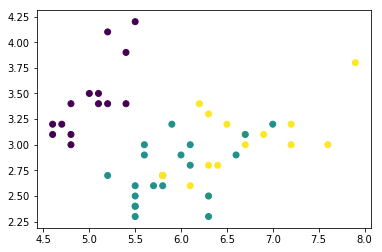

In [309]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test)

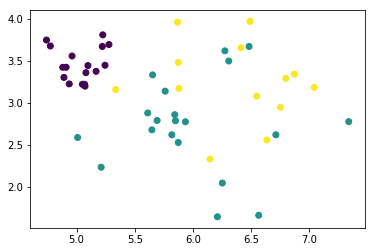

In [313]:
samples = naive_bayes_iris.gaussian_sampling(50)
plt.scatter(samples[:, 0], samples[:, 1], c=samples[:, 4])

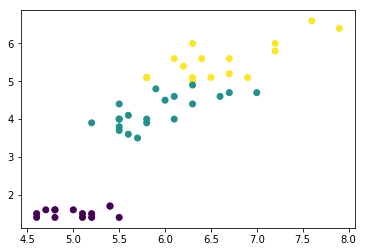

In [314]:
plt.scatter(X_test[:, 0], X_test[:, 2], c=Y_test)

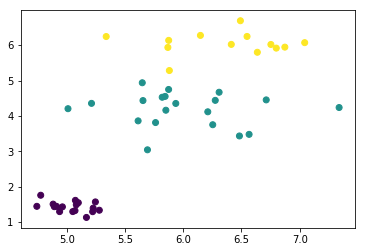

In [315]:
plt.scatter(samples[:, 0], samples[:, 2], c=samples[:, 4])

In [318]:
class NaiveBayes:
    def __init__(self, class_prior, features, n_classes):
        self.class_prior = class_prior
        self.features = features
        self.n_classes = n_classes
        
        self._init_weights()
        
    def _init_weights(self):
        self.weights = []
        
        for i, feature in enumerate(self.features):
            if feature == 'gaussian':
                self.weights.append((self._random_normal(), self._random_normal()))
            
            elif feature == 'bernoulli':
                self.weights.append((self._random_uniform()))
     
    def _random_normal(self, loc_in=0.0, scale_in=1.0, size_in=None):
        if size_in is None:
            size_in = self.n_classes
        
        return np.random.normal(loc=loc_in, scale=scale_in, size=size_in)
    
    def _random_uniform(self, low_in=0.0, high_in=1.0, size_in=None):
        if size_in is None:
            size_in = self.n_classes
        
        return np.random.uniform(low=low_in, high=high_in, size=size_in)
    
    def _random_bernoulli(p_in, n_in=1, size_in=1):
        return np.random.multionimal(n=n_in, pvals=p_in, size=size_in)
        
    def _conditional_log_probability(self, feature, class_index, feature_index):
        if self.features[feature_index] == 'gaussian':
            return - (1/2)*np.log(2*np.pi*self.weights[feature_index][1][class_index]**2) \
                   - (feature-self.weights[feature_index][0][class_index])**2 \
                   / (2*self.weights[feature_index][1][class_index]**2)
        
        elif self.features[feature_index] == 'bernoulli':
            if feature == 0:
                return np.log(1-self.weights[feature_index][class_index])
            else:
                return np.log(self.weights[feature_index][class_index])
    
    def log_likelihood(self, X, Y):
        log_likelihood = 0.0
        
        for x, y in zip(X, Y):
            sum_of_logs = 0.0
            for j, _ in enumerate(self.features):
                sum_of_logs += np.log(self.class_prior[y]) + self._conditional_log_probability(x[j], y, j)
                
            log_likelihood += sum_of_logs
            
        return log_likelihood
    
    def _gaussian_maximum_likelihood_fit(self, feature_number, X, Y):
        means = np.zeros((self.n_classes,))
        counts = np.zeros((self.n_classes,))
        
        for x, y in zip(X, Y):
            means[y] += x
            counts[y] += 1
                
        for i in range(self.n_classes):
             means[i] /= counts[i]
                
        variances = np.zeros((self.n_classes,))
        
        for x, y in zip(X, Y):
            variances[y] += (x - means[y])**2 / counts[y]
                
        for i in range(self.n_classes):
            self.weights[feature_number][0][i] = means[feature_number]
            self.weights[feature_number][1][i] = np.sqrt(variances[feature_number])
            
    def _bernoulli_maximum_likelihood_fit(self, feature_number, X, Y):
        means = np.zeros((self.n_classes,))
        counts = np.zeros((self.n_classes,))
        
        for x, y in zip(X, Y):
            means[y] += x
            counts[y] += 1
                
        for i in range(self.n_classes):
             means[i] /= counts[i]
                
        for i in range(self.n_classes):
            self.weights[feature_number][i] = means[i]
                
    def maximum_likelihood_fit(self, X, Y):
        for j, feature in enumerate(features):
            if feature == 'gaussian':
                _gaussian_maximum_likelihood_fit(j, X[:, j], Y)
            elif feature == 'bernoulli':
                _bernoulli_maximum_likelihood_fit(j, X[:, j], Y)
                
    def predictions(self, X):
        predictions = []
        
        for x in X:
            
            class_predictions = []
            for i in range(self.n_classes):
                
                class_predictions.append(self.log_likelihood([x], [i]))
                
            predictions.append(class_predictions)
            
        return predictions
    
    def sampling(self, n_samples):
        samples = np.empty((n_samples, len(self.features) + 1))
        for i in range(n_samples):
            features = []
            ### sample a class
            sampled_class = np.argwhere(np.random.multinomial(n=1, pvals=self.class_prior) == 1)
            samples[i, -1] = sampled_class
            
            for j, feature in enumerate(self.features):
                if feature == 'gaussian':
                    samples[i, j] = self._random_normal(self.weights[j][0][sampled_class], 
                                                        self.weights[j][1][sampled_class], 
                                                        1)
                elif feature == 'bernoulli':
                    samples[i, j] = self._random_bernoulli(self.weights[j][samples_class])
                
        return samples